# Decision Tree On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Decision Tree algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words(BoW), TF-IDF, Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing required libraries
from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf1

## 3. Loading the data

In [4]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
data.shape

(364171, 12)

In [6]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [7]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# converting 'positive' score to 1 and 'negative' score to 0
def partition(x):
    if x == 'positive':
        return 1
    return 0

actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [10]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [11]:
score = np.array(sorted_data.Score.reshape(sorted_data.shape[0],1))

In [12]:
sorted_data = sorted_data.iloc[:100000,:]
score = score[:100000,:]

In [13]:
sorted_data.shape,score.shape

((100000, 12), (100000, 1))

## 5. Function Definitions

### [A.] Data Spliting 

In [14]:
# Train-Test splitting 
def data_split(data, score):
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size = 0.3, shuffle = False)
    return train_x, test_x, train_y, test_y

### [B.] Decision Tree Classifier

In [15]:
# applying Multinomial Naive Bayes and cross-validating
def cross_val(X, Y, vectorizer):

    # spliting the train data set into cross validation train and cross validation test
    kfold = KFold(3, shuffle=False)

    depth = np.arange(1,300,step = 30)
    cv_err = []
    train_err = []

    for train, cv in kfold.split(X):
        for d in depth:
            dt = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced')

            vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
            train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
            cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
            # fitting the model on cross-validation train
            dt.fit(train_vect,Y[train])

            # predict the response on the cross-validation train
            train_err.append(1 - (dt.score(train_vect, Y[train])))
            cv_err.append(1 - (dt.score(cv_vect, Y[cv])))

    return train_err, cv_err

In [16]:
# applying decision tree on w2v
def dt_w2v(X, Y):
    # spliting the train data set into cross validation train and cross validation test
    kfold = KFold(3, shuffle=False)

    depth = np.arange(1,300,step = 30)
    cv_err = []
    train_err = []

    for train, cv in kfold.split(X):
        for d in depth:
            dt = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced')
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
            train_vect = avg_w2v(X[train], w2v_model)
            cv_vect = avg_w2v(X[cv], w2v_model)
            
            dt.fit(train_vect, Y[train])
            cv_err.append(1 - (dt.score(cv_vect, Y[cv])))
            train_err.append(1 - (dt.score(train_vect, Y[train])))
                    
    return cv_err, train_err

In [76]:
# applying Support Vector Classifier for tfidf-w2v
def dt_tfidf_w2v(X1, Y, raw_x):
    X = np.array(X1)
    cv_err = []
    train_err = []
    depth = np.arange(1,300,step = 30)
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=None)
    for train, cv in Kfold.split(X):
        for d in depth:
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=-1)
            tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
            train_vect = tfidf_w2v(X1[cv.shape[0]:], w2v_model, tfidf_dict)
            cv_vect = tfidf_w2v(X1[:cv.shape[0]], w2v_model, tfidf_dict)
                
            train_vect = np.nan_to_num(train_vect)
            cv_vect = np.nan_to_num(cv_vect)
            
            dt = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced')
            dt.fit(train_vect, Y[train])
                
            cv_err.append(1 - (dt.score(cv_vect, Y[cv])))
            train_err.append(1 - (dt.score(train_vect, Y[train])))
                    
    return train_err, cv_err

### [C.] Error Curve 

In [17]:
# comparing model errors on cv and train data
def error_comparision(train_err, cv_err):
    sns.set()
    depth = np.arange(1, 300, step = 30)
    # plotting error curves
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(depth, cv_err[i, :],label = 'cv_error', color = 'r')
        plt.plot(depth, train_err[i, :],label = 'train_error', color = 'b')
        plt.xlabel('Tree-Depth')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [D.] Accuracy Metrics 

In [18]:
# plotting ROC curve along with confusion matrix
def final_test_acc(train_data, train_score, test_data, test_score, depth, name):
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced')
    dt.fit(train_data, train_score)
    
    
    # TRAIN METRIC
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = dt.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for depth = '{0}' is '{1}'".format(depth, acc_trn))
    ytrn_pred_proba = dt.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='DT', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('DT ROC curve for '+name+' with depth '+str(depth))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    # TEST METRIC
    
    print('\n\n\n\n\n')
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = dt.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize=True) * float(100)
    
    print("\nTest accuracy for depth = '{0}' is '{1}'".format(depth, acc))
    y_pred_proba = dt.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='DT', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('DT ROC curve for '+name+' with depth '+str(depth))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [E.] Grid Search 

In [19]:
# applying grid search to find best c 
def grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    tuned_parameters = [{'max_depth': np.arange(1, 300, step = 30)}]
    
    model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'f1', cv=3, n_jobs=-1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [F.] Random Search 

In [20]:
# applying random search to find best c 
def random_search_cv(data_trn, score_trn, data_test, score_test):
    
    tuned_parameters={'max_depth': stats.norm(300)}
    model = RandomizedSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tuned_parameters, scoring = 'f1', cv=3, n_jobs=-1)
    model.fit(data_trn, score_trn)
                                                                                   
    print(model.best_estimator_)
    print(model.score(data_test, score_test))

## 6. Bag of Words(BoW)

In [21]:
train_x, test_x, train_y, test_y = data_split(sorted_data, score)

In [37]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2), min_df=0)

### [A.] Decision Tree Classifier 

In [63]:
# calculating cv-error and train error
train_err_bow, cv_err_bow = cross_val(train_x, train_y, count_vect)

In [66]:
cv_err_bow = np.reshape(cv_err_bow,(3, 10))
train_err_bow = np.reshape(train_err_bow,(3, 10))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

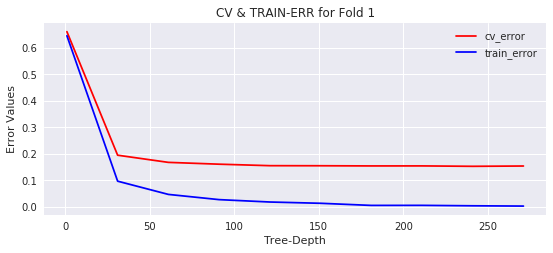

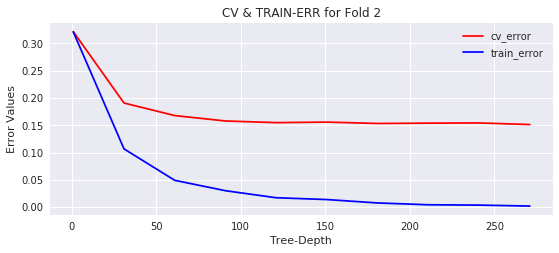

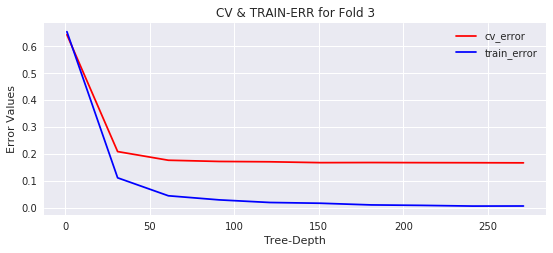

In [67]:
error_comparision(train_err_bow, cv_err_bow)

#### Observation:
* From cv-train and cv-test error comparision it seems like alpha should be 1 as elbow shape is at 1 alpha.

In [38]:
# vectorizer on train and test data
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [39]:
# finding best fit c using grid search (for L1)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=271, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.9087507876496534


### [D.] Random Search 

In [81]:
random_search_cv(final_counts_train, train_y, final_counts_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=300.8373799328965, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.9015239178614156


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '50' is '93.76714285714286'


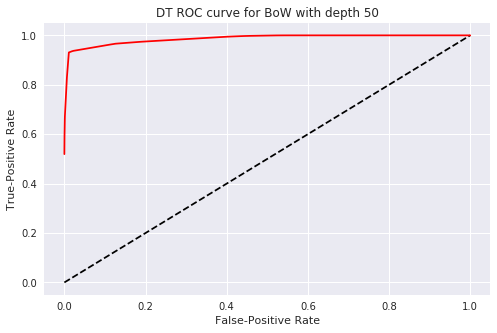

Area under the ROC curve is  0.9864815074960948

Confusion Matrix :
 [[ 8076    92]
 [ 4271 57561]]

Normalized Confusion Matrix :
 [[0.98873653 0.01126347]
 [0.06907427 0.93092573]]

Precision  : 65.41%, 99.84%
Recall     : 98.87%, 93.09%
F1-score   : [0.78732635 0.96348496]


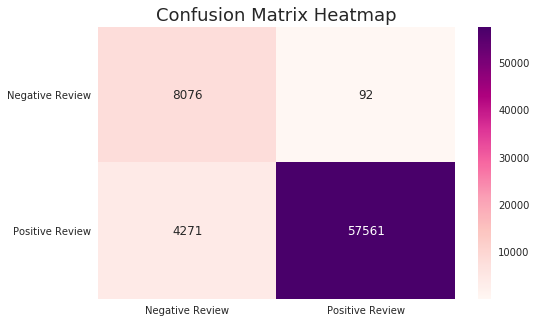







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '50' is '82.56'


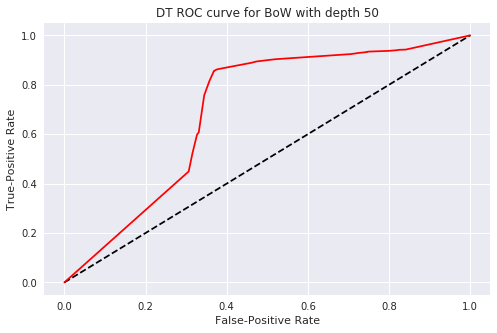

Area under the ROC curve is  0.6951355955200429

Confusion Matrix :
 [[ 2588  1515]
 [ 3717 22180]]

Normalized Confusion Matrix :
 [[0.63075798 0.36924202]
 [0.14353014 0.85646986]]

Precision  : 41.05%, 93.61%
Recall     : 63.08%, 85.65%
F1-score   : [0.49730976 0.89449911]


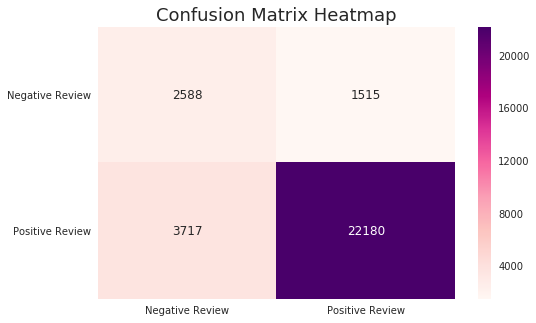

In [40]:
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 50, 'BoW')

#### Observation:
* Test accuracy for alpha=1 is 89.8% if we use BoW representaion for our text-data, which is pretty good.
* True positive rate is 94% but True negative rate is 70%. Due to the positive majority class we are having problem classifing the negative classes. 

## 7. TF-IDF

In [59]:
# applying tf-idf vectorization 
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 0)

### [A.] Decision Tree Classifier 

In [87]:
train_err_tfidf, cv_err_tfidf = cross_val(train_x, train_y, tf_idf_vect)

In [88]:
cv_err_tfidf = np.reshape(cv_err_tfidf,(3, 10))
train_err_tfidf = np.reshape(train_err_tfidf,(3, 10))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

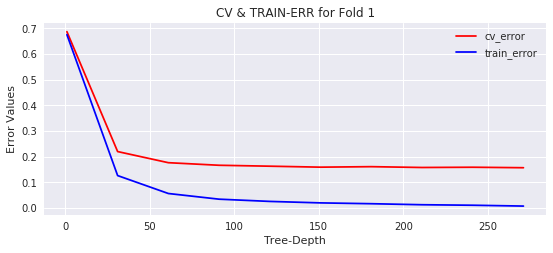

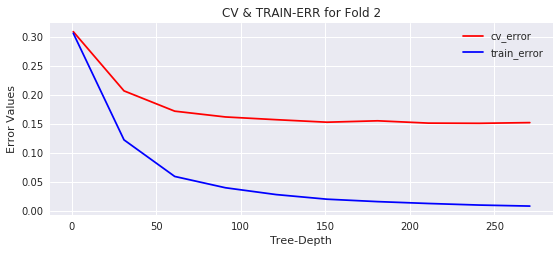

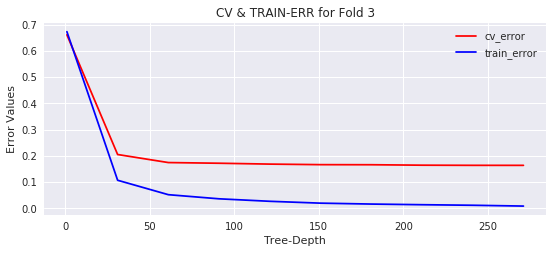

In [89]:
error_comparision(train_err_tfidf, cv_err_tfidf)

#### Observation:
* We are getting a minimum error at alpha=0.01. So best-fit alpha should be 0.01. 

In [60]:
# applying vectorizer to train and test data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_tfidf_train = tfidf_model.transform(train_x['CleanedText'].values)
final_tfidf_test = tfidf_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [91]:
# finding best fit c using grid search (for L1)
grid_search_cv(final_tfidf_train, train_y, final_tfidf_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=241, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.9030250851172074


### [D.] Random Search 

In [92]:
random_search_cv(final_tfidf_train, train_y, final_tfidf_test, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=299.91317747431356, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.904278817021443


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '60' is '93.95285714285714'


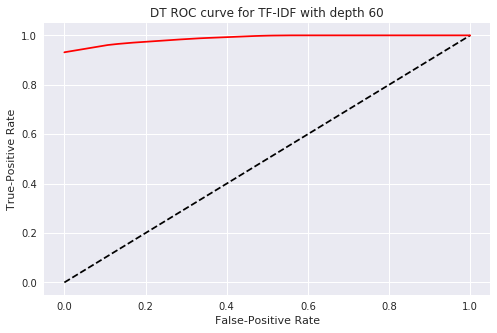

Area under the ROC curve is  0.9877012661175731

Confusion Matrix :
 [[ 8167     1]
 [ 4232 57600]]

Normalized Confusion Matrix :
 [[9.99877571e-01 1.22428991e-04]
 [6.84435244e-02 9.31556476e-01]]

Precision  : 65.87%, 100.00%
Recall     : 99.99%, 93.16%
F1-score   : [0.79418486 0.96455753]


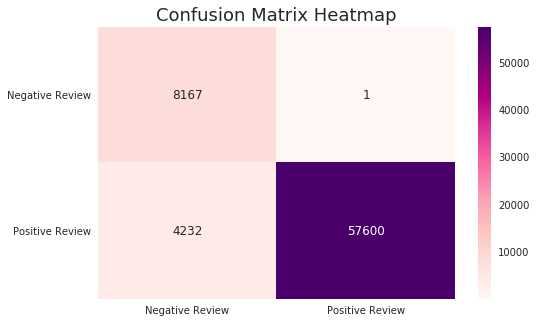







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '60' is '81.71000000000001'


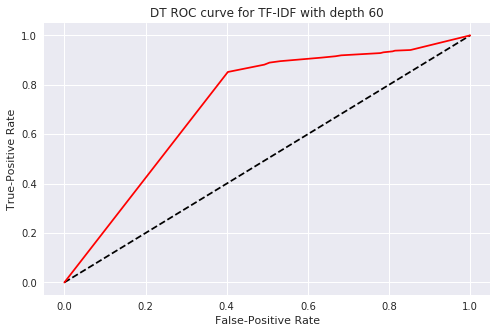

Area under the ROC curve is  0.7219136109526904

Confusion Matrix :
 [[ 2446  1657]
 [ 3830 22067]]

Normalized Confusion Matrix :
 [[0.59614916 0.40385084]
 [0.14789358 0.85210642]]

Precision  : 38.97%, 93.02%
Recall     : 59.61%, 85.21%
F1-score   : [0.47133635 0.88942182]


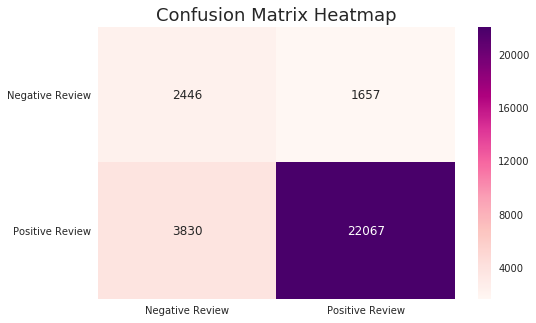

In [93]:
final_test_acc(final_tfidf_train, train_y, final_tfidf_test, test_y, 60, 'TF-IDF')

## 8. Word2Vec

In [67]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [68]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [69]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [97]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [70]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [99]:
train_x, test_x, train_y, test_y = data_split(list_of_sent, score)

### [A.] Decision Tree Classifier 

In [103]:
# applying both L1 & L2 Logistic Regression
cv_w2v, train_w2v = dt_w2v(np.array(train_x), np.array(train_y))

In [104]:
cv_wv = np.reshape(cv_w2v,(3, 10))
train_wv = np.reshape(train_w2v,(3, 10))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

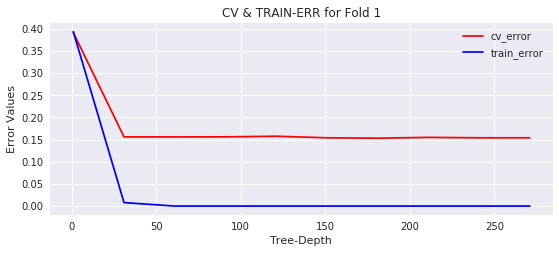

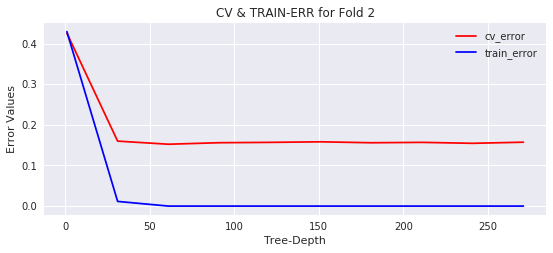

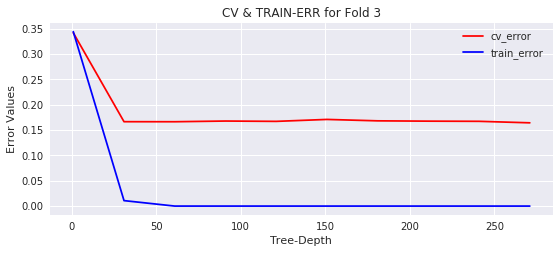

In [105]:
error_comparision(train_wv, cv_wv)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 0.1.

In [106]:
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

### [C.] Grid Search 

In [107]:
grid_search_cv(train_vect, train_y, test_vect, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=181, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.9007481678498306


### [D.] Random Search 

In [108]:
random_search_cv(train_vect, train_y, test_vect, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=300.11133711141485, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.9006275350118619


### [E.] Accuracy Metrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '60' is '99.99'


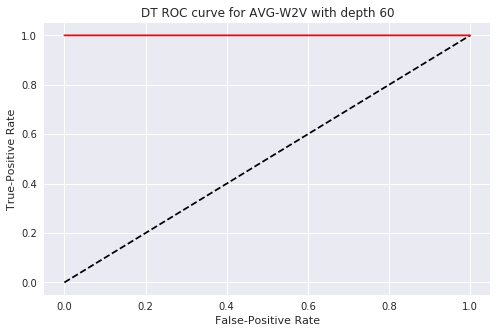

Area under the ROC curve is  0.99999979209723

Confusion Matrix :
 [[ 8168     0]
 [    7 61825]]

Normalized Confusion Matrix :
 [[1.00000000e+00 0.00000000e+00]
 [1.13209988e-04 9.99886790e-01]]

Precision  : 99.91%, 100.00%
Recall     : 100.00%, 99.99%
F1-score   : [0.99957168 0.99994339]


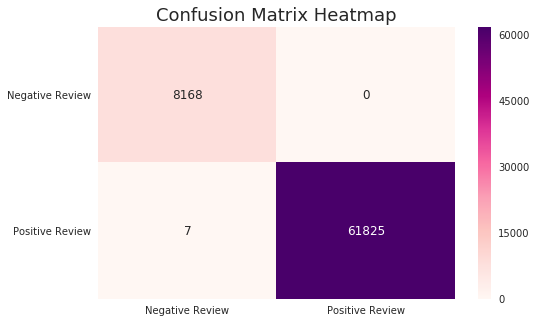







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '60' is '82.57666666666667'


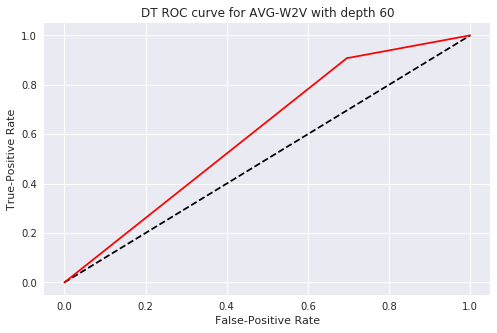

Area under the ROC curve is  0.6057551611663637

Confusion Matrix :
 [[ 1244  2859]
 [ 2368 23529]]

Normalized Confusion Matrix :
 [[0.30319279 0.69680721]
 [0.09143916 0.90856084]]

Precision  : 34.44%, 89.17%
Recall     : 30.32%, 90.86%
F1-score   : [0.32248866 0.90002869]


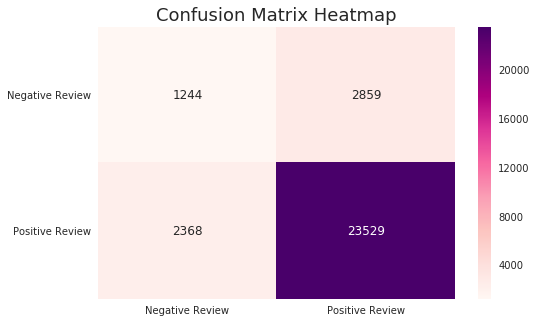

In [109]:
final_test_acc(train_vect, train_y, test_vect, test_y, 60, 'AVG-W2V')

### 9.1 TF-IDF W2V

In [74]:
# Determining TF-IDF weighted Word2Vec
def tfidf_w2v(data, model, tfidf_dict):
    tfidf_feat = tf_idf_vect.get_feature_names() 
    tfidf_sent_vectors = []
    row = 0
    for sent in data: 
        sent_vec = np.zeros(100)
        weight_sum = 0 
        for word in sent: 
            try:
                vec = model.wv[word]
                tf_idf = tfidf_dict[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

In [72]:
train_x, test_x, train_y, test_y, raw_x, raw_y = train_test_split(list_of_sent[:100000], score[:100000], sorted_data.CleanedText[:100000].values,
                                                                 test_size=0.3, shuffle=False)

### [A.] Decision Tree Classifier

In [77]:
# applying linear svc
train_err, cv_err = dt_tfidf_w2v(train_x[:5000], train_y[:5000], raw_x[:5000])

In [79]:
cv_err = np.reshape(cv_err,(3, 10))
train_err = np.reshape(train_err,(3, 10))

### [B.] Error Plot Over Different Values of Hyperparameter (Depth of Tree)

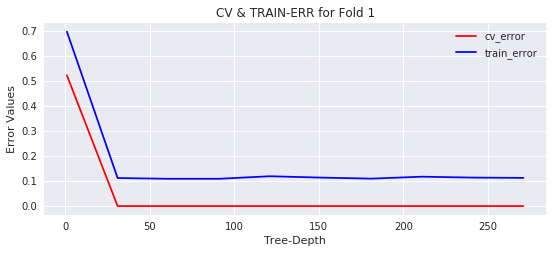

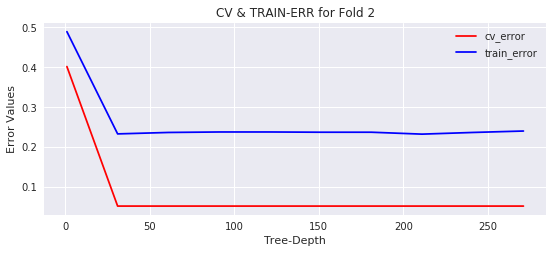

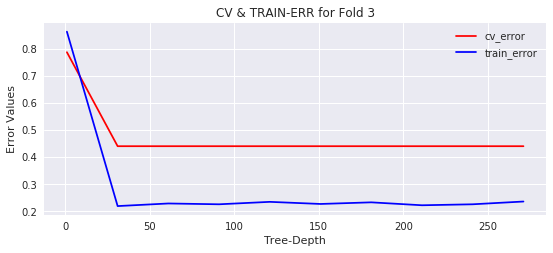

In [80]:
error_comparision(cv_err, train_err)

In [81]:
# applying tf-idf weighted w2v to train and test set 
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=-1)
tfidf_dict = tf_idf_vect.fit_transform(raw_x)
train_vect = tfidf_w2v(list_of_sent[:70000], w2v_model, tfidf_dict)
test_vect = tfidf_w2v(list_of_sent[70000:100000], w2v_model, tfidf_dict)

In [82]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [C.] Grid Search 

In [83]:
# finding best fit alpha using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=61, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8975626130578297


### [D.] Accuracy Metrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for depth = '12' is '73.85714285714286'


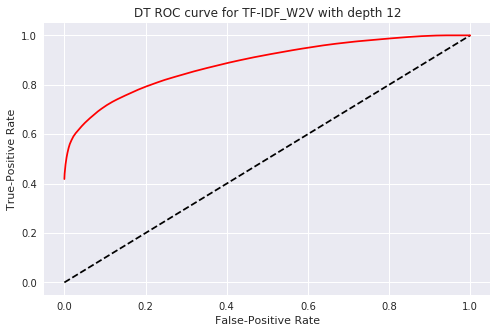

Area under the ROC curve is  0.8850390832259262

Confusion Matrix :
 [[ 7312   856]
 [17444 44388]]

Normalized Confusion Matrix :
 [[0.89520078 0.10479922]
 [0.28211929 0.71788071]]

Precision  : 29.54%, 98.11%
Recall     : 89.52%, 71.79%
F1-score   : [0.44417446 0.82909335]


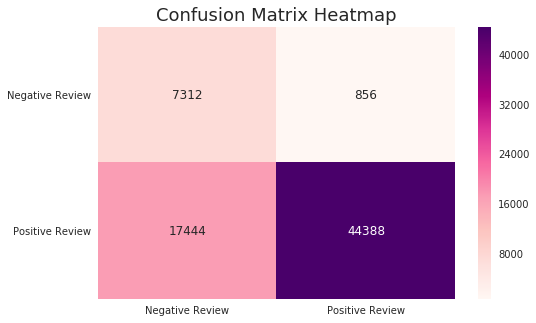







				ACCURACY METRIC FOR TEST-SET


Test accuracy for depth = '12' is '77.56333333333333'


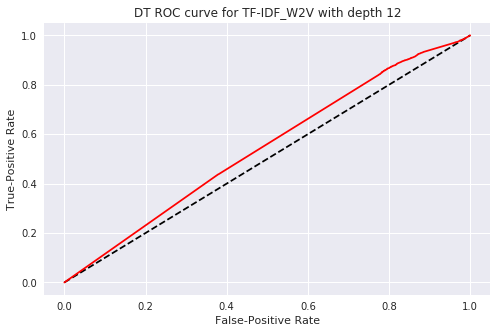

Area under the ROC curve is  0.5443377927055015

Confusion Matrix :
 [[  832  3271]
 [ 3460 22437]]

Normalized Confusion Matrix :
 [[0.20277845 0.79722155]
 [0.13360621 0.86639379]]

Precision  : 19.38%, 87.28%
Recall     : 20.28%, 86.64%
F1-score   : [0.19821322 0.8695669 ]


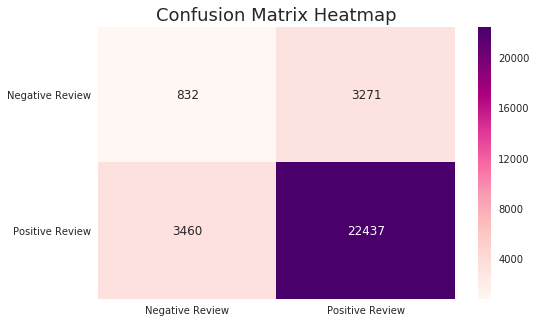

In [90]:
final_test_acc(train_vect, train_y, test_vect, test_y, 12, 'TF-IDF_W2V')

## 10. Summary

### Approach:
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From all Amazon fine food reviews data-points i have taken only the reviews that have score 1, 2, 4 or 5. Then I applied some pre-processing methods to make data best fit to apply naive bayes model. After that I have declared some useful functions to modularize the whole process. For our end goal i.e to classify a review whether it is positive or not by using support vector classifier, we need to convert the textual data to numerial one. To do so i have used these four(given below) vectorization methods.<br>
</p>
<br>
1. Bag of Words(BoW)<br>
2. TF-IDF<br>
3. Avg Word2Vec<br>
4. TF-IDF W2V
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before applying any model to our data we need to split the data into train and test set. Here I have taken 70% of the data(100000 datapoints) as train-set and rest 30% as test-data. The important part here is "I have sorted the data in ascending order of time stamp of the reviews" and then splitted the whole data without shuffling it. The only problem with this data set is that it is a imbalanced dataset i.e there is a mismatch between number of instances of each class. Here i'm having 87729 positive data-points and 12271 negative data-points. It means the given dataset is nearly 87.7% positive & 12.3% negative. 
</p>

<h3> Results:</h3>
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Linear SVC using SGDClassifier we have got alpha which is a hyper-parameter which handles the trade-off between overfitting and underfitting. To find best fit alpha i have used 3-Fold cross validation for each vectorization method and the performance of the model is compared by various accuracy matrics(ROC-AUC curve, precision, recall, F1-Score etc.) for each vectorization.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>1. BoW</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW representation, we got best-fit alpha = 0.00005 from 3-Fold cross validation and grid search. And the accuracy metric for train and test data, taking alpha = 0.00005, is given below:-
 <table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.00005</td>
    <td>97.3%</td>
    <td>81.93%, 99.82%</td>
    <td>98.64%, 97.13%</td>
    <td>0.89 0.98</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.00005</td>
    <td>91.2%</td>
    <td>64.36%, 96.75%</td>
    <td>80.28%, 92.96%</td>
    <td>0.71 0.95</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 97.3% accuracy for train-data and 91.2% for test-data. But from F1-Score it is clear that our model is not that good in predicting negative class compared to the positive prediction. This problem occurs due the imbalanced data, still 0.71 F1-Score for negative prediction is pretty good as total negative data-points are only 12% of total data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>2. TF-IDF</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For TF-IDF representation, we got best-fit alpha = 0.00001 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.00001, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.00001</td>
    <td>99.15%</td>
    <td>93.22%, 100.00%</td>
    <td>99.99%, 99.04%</td>
    <td>0.96 0.99</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.00001</td>
    <td>93%</td>
    <td>72.36%, 96.78%</td>
    <td>80.01%, 95.16%</td>
    <td>0.76 0.96</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 99.15% accuracy with high F1-Scores for train-data and 93% for test-data. But for test-data, negative class F1-Score is 0.76 which is too low compared to positive class F1-Score 0.96. Still the TF-IDF representation helped the model to perform better than BoW.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>3. Avg Word2Vec</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit alpha = 0.001 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.001, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.001</td>
    <td>81.63%</td>
    <td>37.22%, 97.40%</td>
    <td>83.55%, 81.38%</td>
    <td>0.51 0.88</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.001</td>
    <td>81.45%</td>
    <td>41.28%, 97.00%</td>
    <td>84.18%, 81.02%</td>
    <td>0.55 0.88</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 81.63% accuracy with low F1-Scores for train-data and 81.45% for test-data. But for test-data, negative class F1-Score is poor i.e 0.55 which is too low compared to positive class F1-Score 0.88. So Avg Word2Vec didn't help the model to properly classify the given data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>4. TF-IDF W2V</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit alpha = 0.0000001 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.0000001, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.0000001</td>
    <td>88.32%</td>
    <td>49.12%, 88.42%</td>
    <td>1.03%, 99.86%</td>
    <td>0.02 0.94</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.0000001</td>
    <td>81.77%</td>
    <td>23.27%, 87.22%</td>
    <td>14.48%, 92.44%</td>
    <td>0.18 0.90</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 88.32% accuracy with worst negative F1-Score for train-data and 81.77% for test-data. But for test-data, negative class F1-Score is poor i.e 0.18 which is worse.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>SVC with RBF Kernel</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have only implemented linear svc using sklear.SGDClassifier with hinge loss here and found out that the TF-IDF representation worked well among other vectorization. So I applied sklearn.svc.SVC with RBF kernel to TF-IDF representation to check whether it performs better or not.After applying SVC with RBF kernel to the TF-IDF I got best-fit C to be 0.00005 from 3-Fold cross validation. And the accuracy metric for train and test data, taking C = 0.00005, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>C</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.00005</td>
    <td>88.33%</td>
    <td>0.00%, 88.33%</td>
    <td>0.00%, 100.00%</td>
    <td>0. 0.94</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.00005</td>
    <td>86.32%</td>
    <td>0.00%, 86.32%</td>
    <td>0.00%, 100.00%</td>
    <td>0. 0.92</td>
  </tr>
</table>
<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SVC with RBF kernel performed very bad as it assigned all the data points positive i.e assigned with majority class. So in short It performed worse than the random classification.
<h3> Conclusion:</h3><br>
1. The model performed well for both BoW vectorization and TF-IDF vectorization in classifing the review.<br> 
2. The linear SVC model performed well, even the dataset is 88%-12% imbalanced, with 80% true negative rate and nearly 95% true positive rate.<br>
3. As the dimensionality of the feature vector is very large, so the possibility to find a linear separating plane is very high. That's why linear SVC worked far better than the SVC with RBF kernel.